DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 6482
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 976
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2915
    })
})


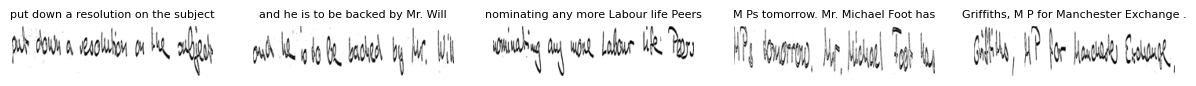

After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64, 2048])
After CNN: torch.Size([16, 512, 4, 64])
After reshaping: torch.Size([16, 64,

: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import cv2
import copy

# Load dataset
dataset = load_dataset("Teklia/IAM-line")
print(dataset)

# Preprocessing & Enhancement
def enhance_image(image):
    image = np.array(image.convert("L"))  # Convert to grayscale NumPy array

    # Apply adaptive thresholding
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY, 15, 8)

    # Morphological operations to remove noise
    kernel = np.ones((2, 2), np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)  # Close small gaps
    image = cv2.GaussianBlur(image, (3, 3), 0)  # Reduce background noise

    # Contrast stretching
    min_pixel, max_pixel = np.percentile(image, (2, 98))  
    image = np.clip((image - min_pixel) * (255.0 / (max_pixel - min_pixel)), 0, 255)
    image = image.astype(np.uint8)

    return Image.fromarray(image)  # Convert back to PIL

class IAMDataset(Dataset):
    def __init__(self, dataset, transform=None, apply_preprocessing=True):
        """
        Custom dataset class for handwritten text recognition.
        """
        self.dataset = dataset  # Assuming dataset is a list or dictionary with 'image' and 'text'
        self.transform = transform
        self.apply_preprocessing = apply_preprocessing

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        
        # Check if 'image' is a list and handle accordingly
        image = sample["image"]
        if isinstance(image, list):
            image = image[0]  # Handle the first image if it's a list

        text = sample["text"]

        # Apply preprocessing if enabled
        if self.apply_preprocessing:
            image = enhance_image(image)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, text  # Return transformed image & corresponding label

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 256), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create dataset instances
train_dataset = IAMDataset(dataset["train"], transform=transform, apply_preprocessing=True)
test_dataset = IAMDataset(dataset["test"], transform=transform, apply_preprocessing=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        image, text = dataset[i]  # Access individual samples directly from the dataset
        axes[i].imshow(image.squeeze(), cmap="gray")
        axes[i].set_title(text, fontsize=8)
        axes[i].axis("off")
    plt.show()

show_samples(train_dataset, num_samples=5)

class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()

        # CNN for Feature Extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # (1, 64, H, W)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # (64, H/2, W/2)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # (128, H/4, W/4)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, H/4, W/4)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # (256, H/4, W/4)
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),  # (256, H/8, W/4)

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # (512, H/8, W/4)
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # (512, H/8, W/4)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),  # (512, H/16, W/4)

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # (512, H/16, W/4)
            nn.ReLU(),
        )

        # BiLSTM for Sequence Modeling
        self.rnn = nn.LSTM(512 * 4, 256, bidirectional=True, num_layers=2, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Apply CNN layers
        x = self.cnn(x)
        
        # Get the dimensions of the output
        batch_size, channels, height, width = x.size()
        
        # Print the shape before reshaping
        print(f"After CNN: {x.shape}")  # Should be [batch_size, 512, height, width]
        
        # Flatten the output for the LSTM (keep batch_size and width, flatten channels * height)
        x = x.view(batch_size, width, channels * height)  # Shape: [batch_size, sequence_length, feature_dim]
        
        # Print the shape after reshaping
        print(f"After reshaping: {x.shape}")  # Should be [batch_size, width, 512*height]
        
        # Pass through LSTM
        x, _ = self.rnn(x)

        # Pass through fully connected layer for each time step
        x = self.fc(x)  # Shape: [batch_size, sequence_length, num_classes]

        return x

# Encoding function
def encode_texts(texts, characters):
    """
    Convert a list of text labels into integer-encoded sequences and their lengths.
    """
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    blank_idx = char_to_idx[' ']  # Ensure that ' ' is the blank token in the character set
    
    encoded_texts = []
    target_lengths = []

    for text in texts:
        encoded_text = [char_to_idx.get(char, blank_idx) for char in text]
        encoded_texts.append(encoded_text)
        target_lengths.append(len(encoded_text))  # Length of each encoded text label

    # Pad the sequences to the maximum length in the batch
    max_length = max(target_lengths)
    padded_targets = [seq + [0] * (max_length - len(seq)) for seq in encoded_texts]

    targets = torch.LongTensor(padded_targets)  # Convert to LongTensor
    target_lengths = torch.LongTensor(target_lengths)  # Convert to LongTensor

    return targets, target_lengths

# CTC Loss
characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,;:/()[]{}#&$%+-=~<>*^'\"@_ \n\t"
ctc_loss = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

# Define Optimizer
model = CRNN(num_classes=len(characters) + 1)  # +1 for CTC blank token
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, train_loader, optimizer, ctc_loss, characters, device):
    model.train()
    total_loss = 0

    for images, texts in train_loader:
        images = images.to(device)
        targets, target_lengths = encode_texts(texts, characters)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)

        optimizer.zero_grad()
        output = model(images)

        # CTC loss requires the input to be in the format [batch, time, output_dim]
        # The output is of shape [batch_size, sequence_length, num_classes]
        output = output.permute(1, 0, 2)  # [time, batch, output_dim]

        loss = ctc_loss(output, targets, input_lengths=torch.full((images.size(0),), output.size(0), dtype=torch.long).to(device),
                        target_lengths=target_lengths)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to evaluate the model on the test set
def evaluate(model, test_loader, ctc_loss, characters, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, texts in test_loader:
            images = images.to(device)
            targets, target_lengths = encode_texts(texts, characters)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)

            output = model(images)
            output = output.permute(1, 0, 2)  # [time, batch, output_dim]

            loss = ctc_loss(output, targets, input_lengths=torch.full((images.size(0),), output.size(0), dtype=torch.long).to(device),
                            target_lengths=target_lengths)
            total_loss += loss.item()

    return total_loss / len(test_loader)

# Training and evaluation loop
num_epochs = 4
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, ctc_loss, characters, device)
    val_loss = evaluate(model, test_loader, ctc_loss, characters, device)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
